In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch.utils.data import Dataset

In [2]:
class CustomDataset(Dataset):
    '''
      data_dir: data가 존재하는 폴더 경로
      transforms: data transform (resize, crop, Totensor, etc,,,)
    '''

    def __init__(self, annotation, data_dir, transforms=None):
        super().__init__()
        self.data_dir = data_dir
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(annotation)
        self.predictions = {
            "images": self.coco.dataset["images"].copy(),
            "categories": self.coco.dataset["categories"].copy(),
            "annotations": None
        }
        self.transforms = transforms

    def __getitem__(self, index: int):
        
        image_id = self.coco.getImgIds(imgIds=index)

        image_info = self.coco.loadImgs(image_id)[0]
        
        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        boxes = np.array([x['bbox'] for x in anns])

        # boxex (x_min, y_min, x_max, y_max) 
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        labels = np.array([x['category_id'] for x in anns])
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        areas = np.array([x['area'] for x in anns])
        areas = torch.as_tensor(areas, dtype=torch.float32)
                                
        is_crowds = np.array([x['iscrowd'] for x in anns])
        is_crowds = torch.as_tensor(is_crowds, dtype=torch.int64)
                                
        segmentation = np.array([x['segmentation'] for x in anns], dtype=object)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([index]), 'area': areas,
                  'iscrowd': is_crowds}

        # transform
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            target['boxes'] = torch.tensor(sample['bboxes'], dtype=torch.float32)

        return image, target, image_id
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

## Visualize Train Data

In [3]:
annotation = '/opt/ml/input/data/train.json'
data_dir = '/opt/ml/input/data'
train_dataset = CustomDataset(annotation, data_dir)

In [16]:
classes = ("UNKNOWN","General trash","Paper","Paper pack","Metal","Glass","Plastic","Styrofoam","Plastic bag", "Battery", "Clothing")
RGB_cols = [(0,0,0),(255,255,0),(0,255,0),(0,0,255),(0,255,255),(255,0,255),(128,0,255),(128,128,128),(255,128,0),(0,255,128),(255,0,0)]
colors = ['#000000','#FFFF00','#00FF00','#0000FF','#00FFFF','#FF00FF','#8000FF','#808080','#FF8000','#00FF80', '#FF0000']

In [17]:
idx = 0

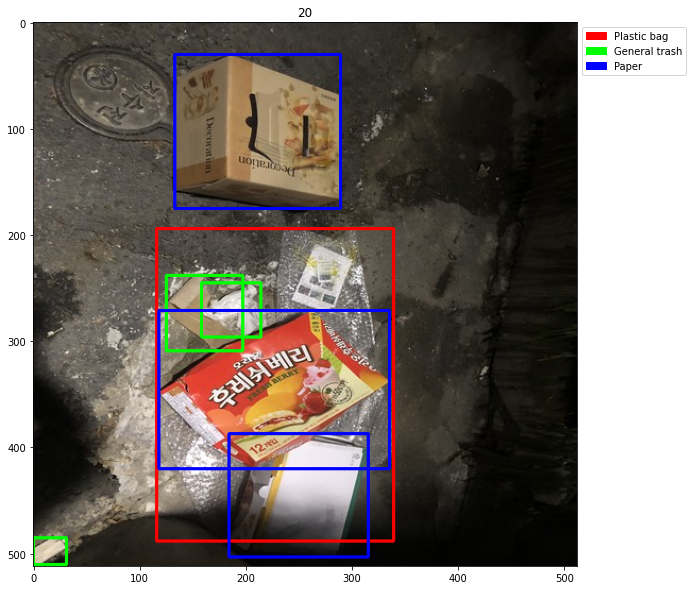

In [120]:
idx += 1

fig, ax = plt.subplots(figsize=(10,10))

image = (train_dataset[idx][0]*255).astype(np.uint8)
boxes = train_dataset[idx][1]['boxes'].astype(np.int)
labels = train_dataset[idx][1]['labels'].cpu().numpy()

legend_list = []
label2col = {}
for i, label in enumerate(set(labels)):
    legend_list.append(mpatches.Patch(color=colors[i], label=classes[label]))
    label2col[label] = i
    
for i in range(len(boxes)):
    ob = cv2.rectangle(image, boxes[i][:2], boxes[i][2:], RGB_cols[label2col[labels[i]]], 2)
    #plt.text((boxes[i][0]+boxes[i][2])/2, boxes[i][1]-2, classes[labels[i]], ha='center', va='bottom',color=colors[label2col[labels[i]]] ,weight='semibold', label=labels[i])
   

plt.legend(handles = legend_list, bbox_to_anchor=(1,1), loc='upper left')
plt.title(idx)
plt.imshow(ob)
plt.show()

## Visualize Inference(Test) Data

In [96]:
# input your submission file`s path
submission_path = '/opt/ml/code/mmdetection_trash/Mybaseline/ensemble/final/final1_scorethr0.1.csv'
submission = np.array(pd.read_csv(submission_path))

In [97]:
classes = ("UNKNOWN","General trash","Paper","Paper pack","Metal","Glass","Plastic","Styrofoam","Plastic bag", "Battery", "Clothing")
RGB_cols = [(0,0,0),(255,255,0),(0,255,0),(0,0,255),(0,255,255),(255,0,255),(128,0,255),(128,128,128),(255,128,0),(0,255,128),(255,0,0)]
colors = ['#000000','#FFFF00','#00FF00','#0000FF','#00FFFF','#FF00FF','#8000FF','#808080','#FF8000','#00FF80', '#FF0000']

In [98]:
idx = -1

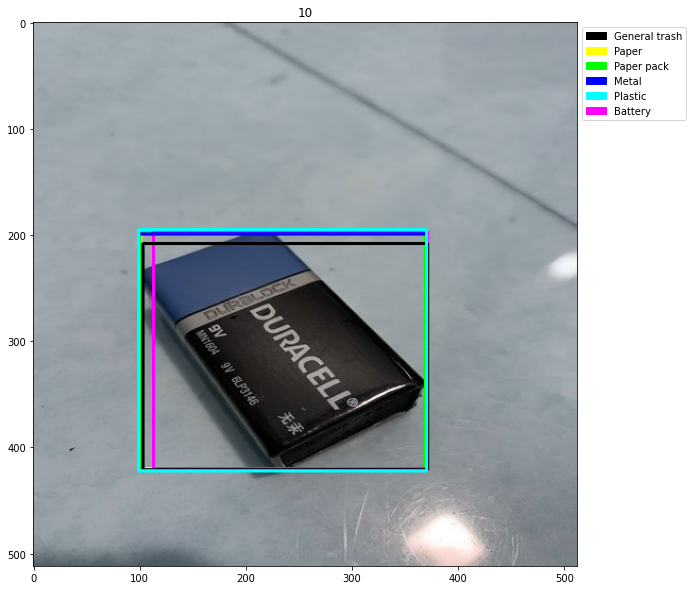

In [109]:
idx += 1

data = submission[idx][0].split()
image_path = '/opt/ml/input/data/' + submission[idx][1]
boxes = []
labels = []

for i in range(0, len(data), 6):
    labels.append(int(data[i]))
    boxes.append([round(float(i)) for i in data[i+2:i+6]])

fig, ax = plt.subplots(figsize=(10,10))

image = cv2.imread(image_path)

legend_list = []
label2col = {}
for i, label in enumerate(set(labels)):
    legend_list.append(mpatches.Patch(color=colors[i], label=classes[label]))
    label2col[label] = i
    
for i in range(len(boxes)):
    ob = cv2.rectangle(image, boxes[i][:2], boxes[i][2:], RGB_cols[label2col[labels[i]]], 2)
    
plt.legend(handles = legend_list, bbox_to_anchor=(1,1), loc='upper left')
plt.title(idx)
plt.imshow(ob)
plt.show()

## Statistics of Train Data

In [91]:
annotation = '/opt/ml/input/data/train.json'
data_dir = '/opt/ml/input/data'
train_dataset = CustomDataset(annotation, data_dir)

loading annotations into memory...
Done (t=4.11s)
creating index...
index created!


In [154]:
box_wh = []
img_id = []

for i in range(len(train_dataset)):
    boxes = train_dataset[i][1]['boxes']
    img_id.append(train_dataset[i][1]['image_id'])
    for box in boxes:
        w = box[2]-box[0]
        h = box[3]-box[1]
        box_wh.append([w, h, h/w, w*h]) # box_wh contains width, height, height/width(ratio), width*height(area)

box_wh = np.array(box_wh)

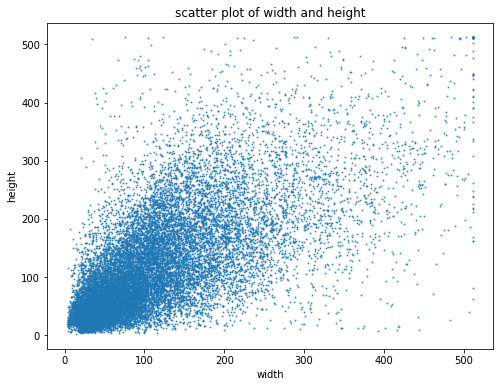

In [155]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(box_wh[:,0], box_wh[:,1], s=1, alpha=0.7)
plt.title('scatter plot of width and height')
plt.xlabel('width')
plt.ylabel('height')
plt.show()

In [163]:
box_wh_df = pd.DataFrame(box_wh, columns=['width','height','ratio','area'])
box_wh_df.describe()

,width,height,ratio,area
count,21116.000000,21116.000000,21116.000000,21116.000000
mean,108.645776,112.751208,1.277337,18051.901280
std,90.702375,92.089715,0.999388,28614.262521
min,3.400000,2.000000,0.016807,27.740000
25%,40.400000,40.500000,0.690845,1751.712500
50%,83.000000,85.000000,1.052390,6854.155000
75%,147.500000,161.500000,1.564431,21905.692500
max,511.900000,511.900000,26.128571,262041.610000
